# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import pandas as pd
import seaborn as sns
from data.data_cleaning import remove_nullrows, median_imputation, abbreviate_features, remove_redundant_features

# Define Path Constants

In [3]:
RAW_PATH = "../data/unprocessed/IMT_Classification_Dataset_matminer_and_handbuilt_v5.xlsx"
SAVE_PATH = "../data/processed/IMT_Classification_Dataset_Processed_v5.xlsx"

# Exploratory Data Analysis

## 1. Read in the [unprocessed dataset](https://github.com/rpw199912j/mit_model_code/blob/master/data/unprocessed/IMT_Classification_Dataset_matminer_and_handbuilt_v3.xlsx)

In [4]:
df_raw = pd.read_excel(RAW_PATH)
df_raw

,Compound,Label,struct_file_path,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,TiS2,0,../data/Structures/Metals/TiS2_52195.cif,16,22,6,18.000000,2.666667,16,43,...,3.460133,3.407300,3.442522,-30.566774,20.696172,43.267170,99.29900,51.805713,6.792914,19.087398
1,SrOsO3,0,../data/Structures/Metals/SrOsO3-Springer.cif,8,76,68,27.600000,23.520000,8,8,...,3.248982,2.859021,2.962374,-42.747293,23.484681,41.000000,55.00000,10.347625,10.509724,12.232597
2,SrRuO3,0,../data/Structures/Metals/SrRuO3_75561.cif,8,44,36,21.200000,15.840000,8,8,...,3.579973,2.760023,2.947568,-44.758483,23.738172,45.000000,59.00000,10.330721,8.527722,12.089967
3,OsO2,0,../data/Structures/Metals/OsO2_15070.cif,8,76,68,30.666667,30.222222,8,57,...,2.805520,2.442651,2.684563,-44.387080,25.269881,41.000000,55.00000,9.953087,13.687053,10.747095
4,SrLaCuO4,0,../data/Structures/Metals/LaSrCuO4_10252.cif,8,57,49,22.285714,16.326531,8,8,...,3.421841,2.662257,2.966018,-36.448400,23.905465,36.841000,57.38000,18.524833,8.820620,13.436088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,YbFe4(CuO4)3,2,../data/Structures/MIT_materials/HighT/YbCu3Fe...,8,70,62,17.850000,11.820000,8,39,...,2.924013,2.552849,2.744642,-33.639068,24.360992,36.841000,57.38000,16.597335,7.361181,9.750947
276,NiSeS,2,../data/Structures/MIT_materials/HighT/NiS(2-x...,16,34,18,26.000000,6.666667,16,61,...,3.287898,2.376963,3.060164,-18.496007,9.778249,18.168838,35.18700,13.516153,8.891048,16.385810
277,Ti2O3,2,../data/Structures/MIT_materials/HighT/Ti2O3_H...,8,22,14,13.600000,6.720000,8,43,...,2.900002,2.771288,2.844355,-33.753924,24.648770,27.491710,43.26717,11.068473,16.169806,10.490597
278,Ca1.2La2.8Mn4O12,2,../data/Structures/MIT_materials/HighT/La0.7Ca...,8,57,49,18.980000,13.176000,8,7,...,3.516261,2.747250,2.906344,-39.888114,22.934073,38.930600,57.57000,14.915598,8.843086,11.576092


We can see that there are 280 rows and 167 columns. Since the `Compound` and `struct_file_path` columns are not predictors and `Label` column is the target/response column, we have **280** compounds and **164** predictors in the unprocessed dataset.

That being said, there are also compounds that have multiple entries in the unprocessed dataset. For instance, some MIT compounds have both a high-temperature structure and a low-temperature structure (i.e. one structure above the transition temperature and another below the transition temperature). As a result, we will only keep 1 entry for each unique compound from now on.

In [5]:
# first sort the compounds by label and compound name alphabetically
df_raw = df_raw.sort_values(by=["Label", "Compound"], ignore_index=True)
# if there are multiple entries, preserve the last one
df_raw = df_raw.drop_duplicates(subset="Compound", keep="last")
df_raw

,Compound,Label,struct_file_path,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_291573.cif,8,56,48,24.400000,19.680000,8,9,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaOsO3,0,../data/Structures/Metals/BaOsO3-Springer.cif,8,76,68,31.200000,27.840000,8,9,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
2,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_73787.cif,8,83,75,28.181818,25.685950,8,56,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
3,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7.cif,8,44,36,17.000000,10.500000,8,7,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
4,CaCrO3,0,../data/Structures/Metals/CaCrO3_245840.cif,8,24,16,13.600000,6.720000,8,7,...,3.283740,2.677252,2.813798,-46.438514,25.057295,49.160000,69.460000,16.458029,7.076892,10.539100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,8,23,15,13.217391,6.805293,8,46,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
273,VO,2,../data/Structures/MIT_materials/HighT/VO_HT_7...,8,23,15,15.500000,7.500000,8,46,...,2.880046,2.880046,2.880046,-24.713293,24.713293,14.634000,29.311100,9.677301,20.010987,8.446042
276,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,8,23,15,13.000000,6.666667,8,46,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
277,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3-6...,8,39,31,18.200000,12.240000,8,12,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816


As we can see, there are **225** unique compounds.

## 2. Explore missing values

In [6]:
columns_na_info = pd.DataFrame(df_raw.isna().sum(), columns=["num_na"])

In [7]:
columns_na_info[columns_na_info.num_na != 0]

,num_na
minimum oxidation state,15
maximum oxidation state,15
range oxidation state,15
std_dev oxidation state,15
gii,49
max_mm_dists,1
min_mm_dists,1
avg_mm_dists,1
max_mx_dists,1
min_mx_dists,1


## 3. Explore target variable

In [8]:
df_raw.Label.value_counts()

1    114
2     73
0     38
Name: Label, dtype: int64

Here is a table that shows what each value mean in the target variable

|value|meaning|
|:----|:------|
|2    |MIT    |
|1    |Insulator|
|0    |Metal  |

We can immediately see that if we were to make a classification model, the input dataset will **imbalanced**.

## 4. Predictor correlation

### Randomly sample 10 features to create a correlation matrix

In [9]:
corr_df = df_raw.drop(columns="Label").sample(n=10, axis=1, random_state=31415926).corr()

### Make a heatmap

<AxesSubplot:>

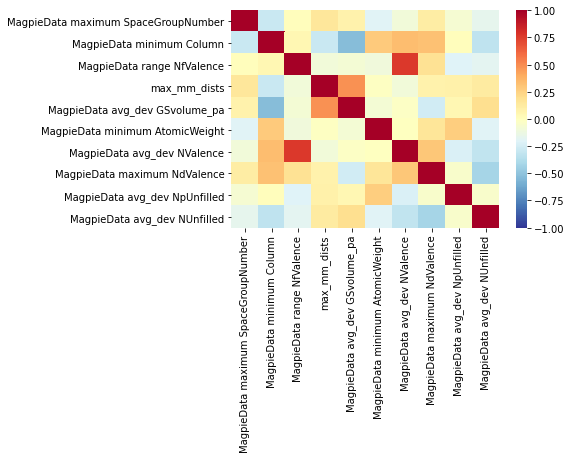

In [10]:
sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, cmap="RdYlBu_r")

# Data cleaning workflow

## 1. Remove rows with at least 6 NaN values

In [11]:
df_processed = remove_nullrows(df_raw, 6)

In [12]:
df_processed.shape[0] - df_raw.shape[0]

-1

We can see that we only dropped 1 row after this step

## 2. Impute the missing values with the median of the corresponding feature within each label group

We first group the dataframe by the column `Label`, find the median for each column within each `Label` group and then impute the missing values with those medians.

In [13]:
df_processed = median_imputation(df_processed)

We can also confirm if all the missing values are indeed filled with mean values.

In [14]:
pd.DataFrame(df_processed.isna().sum(), columns=["num_na"])[columns_na_info.num_na != 0]

,num_na
minimum oxidation state,0
maximum oxidation state,0
range oxidation state,0
std_dev oxidation state,0
gii,0
max_mm_dists,0
min_mm_dists,0
avg_mm_dists,0
max_mx_dists,0
min_mx_dists,0


## 3. Rename the columns for easier readability and plotting

In the heatmap, you might see that there are feautures with a "MagpieData" prefix. This step delete all those prefixes from the variable names.

In [15]:
df_processed = abbreviate_features(df_processed)

## 4. Remove columns with zero variance and high correlations

In [16]:
df_processed = remove_redundant_features(df_processed)

In [17]:
df_processed.shape[1] - df_raw.shape[1]

-62

Just by removing the highly correlated columns, we reduce the number of columns by 62.

## 5. Save the processed dataset

In [18]:
df_processed.to_excel(SAVE_PATH, index=False)
df_processed

,Compound,Label,struct_file_path,maximum MendeleevNumber,range MendeleevNumber,avg_dev MendeleevNumber,range AtomicWeight,mean AtomicWeight,avg_dev AtomicWeight,mode AtomicWeight,...,max_xx_dists,min_xx_dists,avg_xx_dists,v_m,v_x,iv,iv_p1,est_hubbard_u,est_charge_trans,volumn_per_sites
0,BaMoO3,0,../data/Structures/Metals/BaMoO3_291573.cif,87,78,27.600000,121.32760,56.257040,48.309168,15.9994,...,2.857256,2.857256,2.857256,-44.108215,23.006209,40.330000,54.417000,10.523409,11.946426,13.195395
1,BaOsO3,0,../data/Structures/Metals/BaOsO3-Springer.cif,87,78,25.920000,174.23060,75.111040,70.933968,15.9994,...,3.100000,2.893540,2.978994,-36.659700,22.481523,41.000000,55.000000,8.412244,3.591515,16.289915
2,Bi2Ru2O7,0,../data/Structures/Metals/Bi2Ru2O7_73787.cif,87,31,9.157025,192.98100,66.554236,64.342519,15.9994,...,3.691300,2.717536,3.077187,-47.298875,24.715398,45.000000,59.000000,10.043255,11.876142,12.393497
3,Ca3Ru2O7,0,../data/Structures/Metals/Ca3Ru2O7.cif,87,80,29.361111,85.07060,36.197483,23.564431,15.9994,...,3.488882,2.740999,2.933553,-43.378203,25.385677,45.000000,59.000000,10.277936,8.827434,12.120246
4,CaCrO3,0,../data/Structures/Metals/CaCrO3_245840.cif,87,80,28.320000,35.99670,28.014460,14.418072,15.9994,...,3.283740,2.677252,2.813798,-46.438514,25.057295,49.160000,69.460000,16.458029,7.076892,10.539100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,V8O15,2,../data/Structures/MIT_materials/HighT/V8O15_H...,87,41,18.601134,34.94210,28.153174,15.852749,15.9994,...,3.474319,2.529565,2.819850,-38.212724,31.173210,42.359525,60.638487,13.875184,11.940681,9.935308
273,VO,2,../data/Structures/MIT_materials/HighT/VO_HT_7...,87,41,20.500000,34.94210,33.470450,17.471050,15.9994,...,2.880046,2.880046,2.880046,-24.713293,24.713293,14.634000,29.311100,9.677301,20.010987,8.446042
276,VO2,2,../data/Structures/MIT_materials/HighT/VO2_HT_...,87,41,18.222222,34.94210,27.646767,15.529822,15.9994,...,2.725617,2.575183,2.675472,-45.333235,26.337259,46.709000,65.281650,14.484546,9.779242,9.863262
277,YNiO3,2,../data/Structures/MIT_materials/HighT/YNiO3-6...,87,75,24.240000,72.90645,39.119490,27.744108,15.9994,...,3.184308,2.736503,2.827539,-36.802534,23.821848,35.187000,54.920000,15.898371,10.393278,10.686816
